In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pprint import pprint
if torch.cuda.is_available():  
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(device)

data_dim = 512

cuda:0


In [2]:
dataset_training = datasets.ImageFolder('./data/training/training', transform=transforms.Compose([transforms.Resize((data_dim,data_dim)),transforms.ToTensor()]))
dataset_target = datasets.ImageFolder('./data/training/target', transform=transforms.Compose([transforms.Resize((data_dim,data_dim)), transforms.Grayscale() , transforms.ToTensor()]))

In [3]:
def max_map(a,b):
    if a > 0.0:
        return 1.0
    return 0.0

class ImageMapDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, target_data):
        
        self.tensor_data = []     
        self.tensor_target = []
        for i in range(0,len(input_data)):
            self.tensor_data.append(input_data[i][0])
            tar = target_data[i][0]
            tar[tar > 0.0] = 1
            self.tensor_target.append(tar)
        
        # Stack lists into tensors and ship to GPU
        self.tensor_data = torch.stack(self.tensor_data).to(device)
        self.tensor_target = torch.stack(self.tensor_target).to(device)
        
        
        
    def __len__(self):
        return self.tensor_data.shape[0]
    def __getitem__(self, idx):
        return self.tensor_data[idx], self.tensor_target[idx]

In [4]:
data = ImageMapDataset(dataset_training, dataset_target)

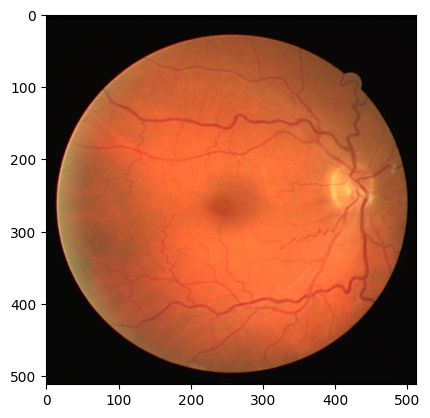

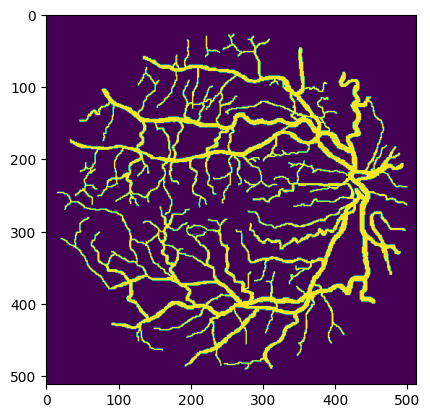

In [5]:
# Display an example image / target pair
for i in range(0,2):
    plt.imshow( transforms.functional.to_pil_image(data[1][i]))
    plt.show()

In [6]:
batch_size = 1

# finally a dataloader I can be happy with!!
data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=0)

In [7]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.sig = nn.Sigmoid()
        # down sampling
        
        self.conv1_1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = "same") 
        self.conv2_1 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = "same") 
        self.pool1 = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        
        self.conv1_2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = "same") 
        self.conv2_2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = "same") 
        self.pool2 = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        
        self.conv1_3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = "same") 
        self.conv2_3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = "same") 
        self.pool3 = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        
        self.conv1_4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = "same") 
        self.conv2_4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = "same") 
        self.pool4 = nn.MaxPool2d(kernel_size = 2 , stride = 2)
                
        self.conv1_5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = "same") 
        self.conv2_5 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = "same")     
    
        # up sampling
        self.up_1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size =2, stride=(2,2), padding=0)
        self.upconv1_1 = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = "same")
        self.upconv2_1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = "same")
        
        self.up_2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size =2, stride=(2,2), padding=0)
        self.upconv1_2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = "same")
        self.upconv2_2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = "same")

        self.up_3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size =2, stride=(2,2), padding=0)
        self.upconv1_3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = "same")
        self.upconv2_3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = "same")
        
        self.up_4 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size =2, stride=(2,2), padding=0)
        self.upconv1_4 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = "same")
        self.upconv2_4 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = "same")
        
        # top level
        self.final_conv = nn.Conv2d(in_channels = 16, out_channels = 1, kernel_size = 1, padding = "same")
        
    def forward(self, x):
        # layer 1 
        x = self.conv1_1(x)
        self.relu(x)
        x = self.conv2_1(x)
        self.relu(x)
        layer1 = x
        x = self.pool1(x)
        
        # layer 2
        x = self.conv1_2(x)
        self.relu(x)
        x = self.conv2_2(x)
        self.relu(x)
      
        layer2 = x
        x = self.pool2(x)
        
        # layer 3
        
        x = self.conv1_3(x)
        self.relu(x)
        x = self.conv2_3(x)
        self.relu(x)
        
        layer3 = x
        x = self.pool3(x)
        
        # layer 4 
        
        x = self.conv1_4(x)
        self.relu(x)
        x = self.conv2_4(x)
        self.relu(x)
     
        layer4 = x
        x = self.pool4(x)
        
        # layer 5 
        x = self.conv1_5(x)
        self.relu(x)
        x = self.conv2_5(x)
        self.relu(x)
        
        # up sampling
        
        x = self.up_1(x)
        x = self.upconv1_1(torch.cat((layer4, x),1))
        self.relu(x)
        x = self.upconv2_1(x)
        self.relu(x)
        
        x = self.up_2(x)
        x = self.upconv1_2(torch.cat((layer3, x),1))
        self.relu(x)
        x = self.upconv2_2(x)
        self.relu(x)
        
        x = self.up_3(x)
        x = self.upconv1_3(torch.cat((layer2, x),1))
        self.relu(x)
        x = self.upconv2_3(x)
        self.relu(x)
                
        x = self.up_4(x)
        x = self.upconv1_4(torch.cat((layer1, x),1))
        self.relu(x)
        x = self.upconv2_4(x)
        self.relu(x)
        
        x = self.sig(self.final_conv(x))
        
        return x



In [8]:
model = Unet().to(device)

# Training

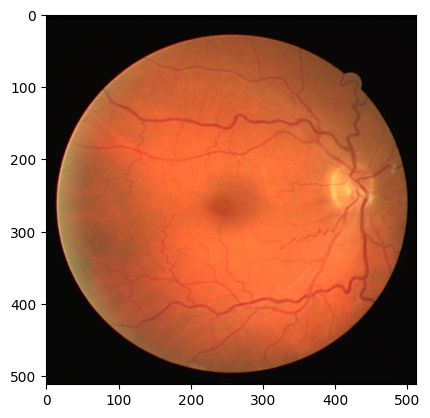

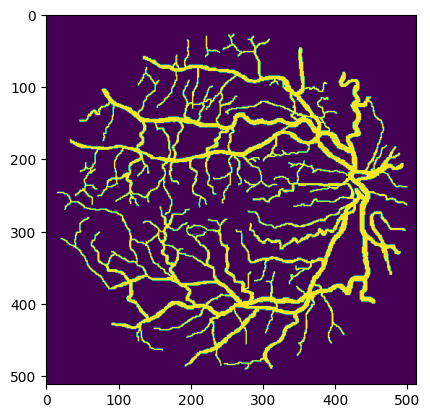

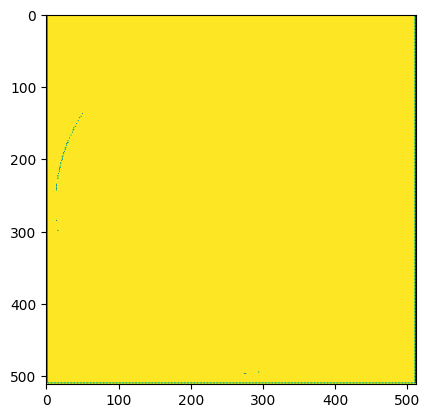

In [9]:
plt.imshow( transforms.functional.to_pil_image(data[1][0]))
plt.show()
plt.imshow( transforms.functional.to_pil_image(data[1][1]))
plt.show()
y = model(data[1][0].reshape(1,3,data_dim,data_dim))
plt.imshow( transforms.functional.to_pil_image(y.reshape((1,data_dim,data_dim))))
plt.show()

In [10]:
from torch.optim import Adam
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [11]:
num_epochs = 10

In [12]:
def train_epoch(epoch_index):
    loss_total = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(data_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss_total += loss
        loss.backward()

        # Adjust learning weights
        optimizer.step()

    return torch.linalg.norm(loss_total)

In [13]:
for i in range(num_epochs):
    print("Epoch ", i, "loss was ", train_epoch(i))
    
    

Epoch  0 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch  1 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch  2 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch  3 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch  4 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch  5 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch  6 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch  7 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch  8 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Epoch  9 loss was  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


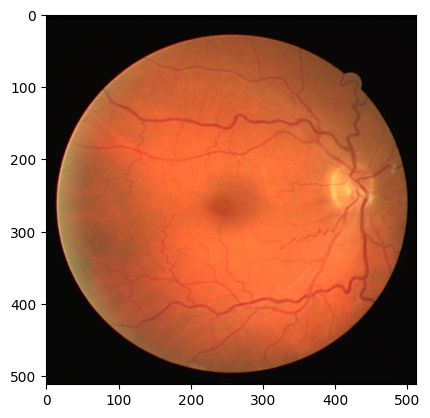

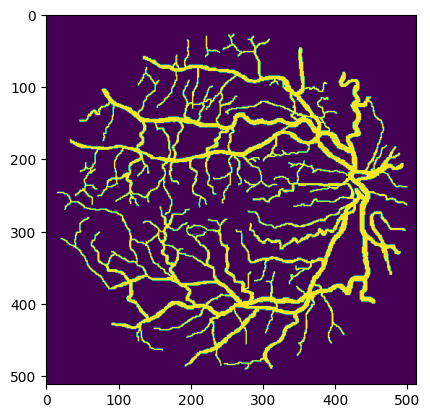

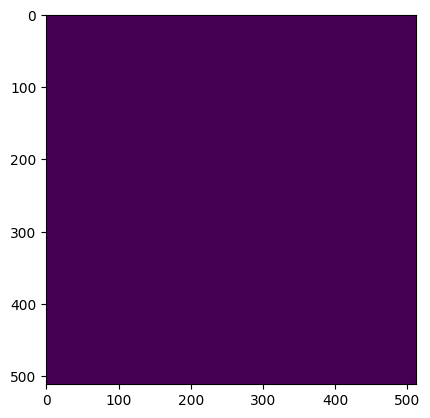

In [14]:
plt.imshow( transforms.functional.to_pil_image(data[1][0]))
plt.show()
plt.imshow( transforms.functional.to_pil_image(data[1][1]))
plt.show()
plt.imshow( transforms.functional.to_pil_image(model(data[1][0].reshape(1,3,data_dim,data_dim)).reshape((1,data_dim,data_dim))))
plt.show()

# Conclusions
- it doesn't work
- only predicts the background
- as the lines in the data are thin small, the background is a good(ish) approximation of the photo

### Next attempt:
- add 2d batch norm
- increase model complexity
- implement it with better programming practices (nn.module, etc.)